# <center> Project-3. Предсказание рейтинга отелей по данным сайта Booking  

In [275]:
# импорт необходимых библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# устанавливаем библиотеку
# !pip install nltk



In [276]:
# всегда фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [277]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [278]:

# Подгрузим наши данные из соревнования

# для решения на Kaggle
# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# для решения локально
DATA_DIR = 'data'
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн


In [279]:

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# sample data для трейна
df_train = df_train.sample(frac = 0.1, replace = False, random_state=42)

# такое название пока для того, чтобы не переписывать переменные в дальнейшем коде
sample_data = pd.concat([df_test, df_train], axis=0, ignore_index=True)
# sample_data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


## <center> Анализ текста отзывов

Данный раздел сделан с учетом рекомендаций Сергея Добдина.

### <center> Работа с отзывами

Объединить положительные и отрицательные отзывы. Дальнейшую работу производим с данным признаком.

In [280]:

# объединяем положительные и отрицательные отзывы
sample_data['review'] = sample_data['negative_review'] + sample_data['positive_review']

# создаём метку для плохого отзыва (1 - True, 0 - False, 2 - для тестовой выборки)
def bad_rewiew(x):
    if x == 0:
        return 2
    elif x < 5:
        return 1
    else:
        return 0
        
sample_data["is_bad_review"] = sample_data["reviewer_score"].apply(bad_rewiew)

# выбираем только релевантные столбцы для работы над отзывами
reviews_df = sample_data.loc[:, ["review", "is_bad_review", "reviewer_score", "sample"]]
reviews_df.head()

,review,is_bad_review,reviewer_score,sample
0,Would have appreciated a shop in the hotel th...,2,0.0,0
1,No tissue paper box was present at the roomNo...,2,0.0,0
2,Pillows Nice welcoming and service,2,0.0,0
3,No Negative Everything including the nice upgr...,2,0.0,0
4,No Negative Lovely hotel v welcoming staff,2,0.0,0


### <center> Очистка данных

In [281]:
# удалим 'No Negative' или 'No Positive' из текста
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", " ").replace("No Positive", " "))
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("nothing", " ").replace("nothing", " "))
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("Nothing", " ").replace("Nothing", " "))

In [282]:
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
# использование wordnet для анализа частей речи

import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания 
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # лемматизация текста
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из одной буквы
    text = [t for t in text if len(t) > 1]
    # объединяем текст
    text = " ".join(text)
    return(text)

# очистка текстовых данных
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Т.к выполнение кода выше занимает до 6 минут сохраняем в csv.

In [284]:
reviews_df.to_csv('data/reviews.csv', index=False)

In [309]:
reviews_df = pd.read_csv('data/reviews.csv')

# заоплняем пустые строки с признаке 'review_clean' значением 'everything' - т.к это является модой и для плохих и для хороших отзывов
reviews_df['review_clean'] = reviews_df['review_clean'].fillna(reviews_df[reviews_df['is_bad_review'] == 0]['review_clean'].mode()[0])

### <center> Создание новых признаков

In [310]:
# https://habr.com/ru/company/Voximplant/blog/446738/
# анализ тональности (настроения) текста отзыва

reviews_df["review"] = reviews_df["review"].fillna(' ')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dolzh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


второе промежуточное сохранение

In [311]:
reviews_df.to_csv('data/reviews_2.csv', index=False)

In [419]:
reviews_df = pd.read_csv('data/reviews_2.csv')

In [420]:
# создадим признак кол-во символов в отзыве
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# создадим признак кол-во слов в отзыве
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [421]:
# https://habr.com/ru/post/585838/
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# получим список из taggedDocument, которые являются кортежами из
# списка слов0 в отзыве и тега, соответсвующего порядковому номеру отзыва
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# обучение модели Doc2Vec с помощью текстовых данных
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# преобразуем каждый документ в вектор данных
doc2vec_df = reviews_df["review_clean"].astype('str').apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [422]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   review            167615 non-null  object 
 1   is_bad_review     167615 non-null  int64  
 2   reviewer_score    167615 non-null  float64
 3   sample            167615 non-null  int64  
 4   review_clean      167615 non-null  object 
 5   neg               167615 non-null  float64
 6   neu               167615 non-null  float64
 7   pos               167615 non-null  float64
 8   compound          167615 non-null  float64
 9   nb_chars          167615 non-null  int64  
 10  nb_words          167615 non-null  int64  
 11  doc2vec_vector_0  167615 non-null  float32
 12  doc2vec_vector_1  167615 non-null  float32
 13  doc2vec_vector_2  167615 non-null  float32
 14  doc2vec_vector_3  167615 non-null  float32
 15  doc2vec_vector_4  167615 non-null  float32
dtypes: float32(5), float

третье промежуточное сохранение

In [423]:
# reviews_df.to_csv('data/reviews_3.csv', index=False)
reviews_df = pd.read_csv('data/reviews_3.csv')

In [424]:
# создание признака tf-idfs (оценка важности слова в тексте)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).astype('int8').toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [425]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Columns: 6822 entries, review to word_zuid
dtypes: float64(10), int64(4), int8(6806), object(2)
memory usage: 1.1+ GB


In [427]:
# object_columns = [s for s in data.columns if data[s].dtypes == 'object']
# data.drop(object_columns, axis = 1, inplace=True)
# for col in reviews_df[reviews_df.dtypes == 'int8'].columns:
#     print(col)

cols_int8 = [s for s in reviews_df.columns if reviews_df[s].dtypes == 'int8']
for i in cols_int8:
    if reviews_df[i].mean() == 0:
        reviews_df = reviews_df.drop(columns=[i])
    # if reviews_df[i].mean() == 0:
    #     reviews_df.drop(i, axis = 1, inplace=True)

In [429]:
reviews_df.to_csv('data/reviews_4.csv', index=False)
reviews_df = pd.read_csv('data/reviews_4.csv')

In [436]:
# признаки со словом word -> int8 (500+ mb -> 83 mb)
for i in reviews_df.columns:
    if 'word' in i and i != 'nb_words':
        reviews_df[i] = reviews_df[i].astype('int8')

In [437]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Columns: 413 entries, review to word_yes
dtypes: float64(10), int64(4), int8(397), object(2)
memory usage: 83.9+ MB


### <center> Исследовательский анализ данных

In [439]:
reviews_df["is_bad_review"].value_counts(normalize = True)

2    0.769233
0    0.221054
1    0.009713
Name: is_bad_review, dtype: float64

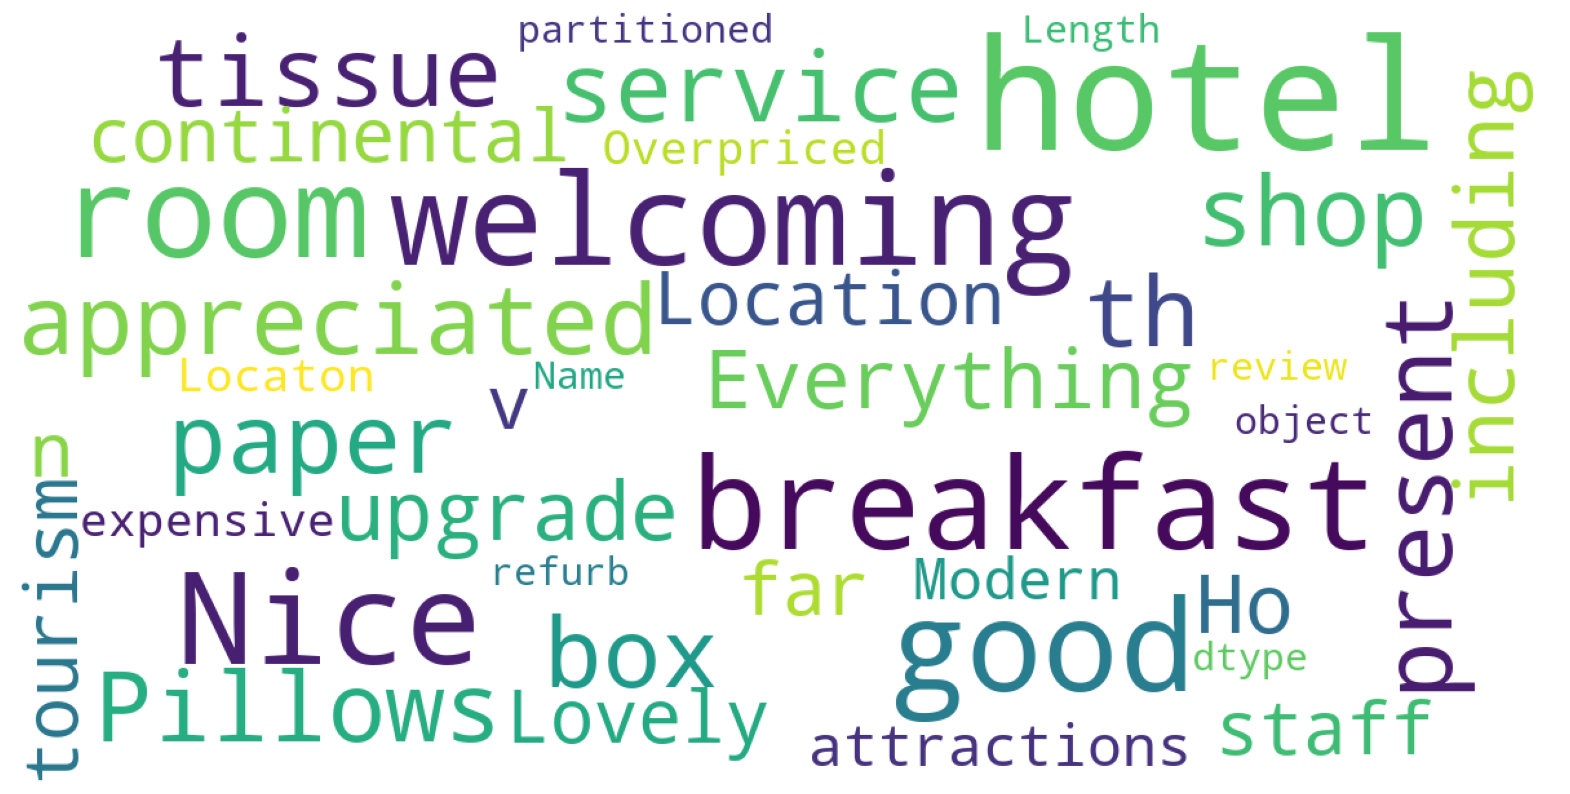

In [440]:
# использование wordcloud функции

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews_df["review"])

In [442]:
# Топ позитивных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
126956,Brilliant,1.0
113045,Fitness special,1.0
89284,Awesome,1.0
164505,Perfectly fine,1.0
3719,perfect,1.0
37569,Excellent value,1.0
41566,Nice lobby,1.0
79905,Classy calm perfect,1.0
94240,Perfect,1.0
138183,Yes yes,1.0


In [443]:
# Топ негативных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
52843,Ignorance,1.000
37351,Bad A C,1.000
32377,A disaster,1.000
74453,All No no no,0.868
73249,Abusive sarcastic m staff,0.861
123577,Weak shower pressure,0.836
4592,No dislikes LOCATION,0.831
2199,Weird uncomfortable bathtub,0.811
129834,There s no downside,0.808
119509,dirty old bad food noisy,0.802


## <center> Создание новых признаков из оставшихся признаков

#### Из признака `hotel_address`

Из признака `hotel_address` получаем признак города

In [444]:
hotels_info = pd.DataFrame()
# функция выделения из адреса города
def adress_analysis(text):
    if text.split()[-1] == 'Kingdom':
        city = text.split()[-5]
        country = ' '.join(text.split()[-2:])
    else:
        city = text.split()[-2]
        country = text.split()[-1]
    return city

# создаем признак города
hotels_info['city'] = sample_data['hotel_address'].apply(adress_analysis)

Кодируем признак города

In [445]:

import category_encoders as ce # импорт для работы с кодировщиком
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['city'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем исходный признак города
hotels_info = hotels_info.drop(columns=['city'])

d:\Users\dolzh\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [446]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0


#### Из признака `reviewer_nationality`

Кодируем признак национальности ревьюэра оставившего отзыв

In [447]:

# убираем лишние пробелы из элементов признака
hotels_info['reviewer_nationality'] = sample_data['reviewer_nationality'].apply(lambda x: x.strip().lower())

# создаем список из 10 наиболее часто встречающихся национальностей
most_common_nations = hotels_info['reviewer_nationality'].value_counts(normalize=True)[:10].index.tolist()

# оставляем только национальности из списка, остальные Other
hotels_info['reviewer_nationality'] = hotels_info['reviewer_nationality'].apply(lambda x: x if x in most_common_nations else 'other')

# применяем однократное кодирование для признака (11 признаков)
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['reviewer_nationality'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем признак национальности
hotels_info = hotels_info.drop(columns=['reviewer_nationality'])


d:\Users\dolzh\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [448]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,reviewer_nationality_8,reviewer_nationality_9,reviewer_nationality_10,reviewer_nationality_11
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


#### Из признака `tags`

In [449]:
# функция перевода текста тегов в список
def tags_to_list(text):
    tag_list = text[2:-2].split('\', \'')
    tag_list = [i.strip().lower() for i in tag_list]
    return tag_list

hotels_info['tags'] = sample_data['tags'].apply(tags_to_list)

In [450]:
hotels_info['tags'].head(2)

0    [leisure trip, couple, double room, stayed 2 n...
1    [leisure trip, group, triple room, stayed 1 ni...
Name: tags, dtype: object

Работа с наиболее часто встречающимися тегами

In [451]:
# создаём пустой список тегов
tags = []
# каждый новый встречающийся тег из каждой строки признака тегов добавляем в список
for tag_list in hotels_info['tags']:
    for tag in tag_list:
        tags.append(tag)
        
from collections import Counter
cnt = Counter(tags)

# Для тегов, встречающихся более 2000 раз, создаем отдельные признаки в новом датасете.
# Так же учитываем, что не рассматриваем теги, с количеством ночей. Из этих тегов получим количество ночей.
for i in cnt.most_common():
    if i[1] > 2000 and 'night' not in i[0]:
        feature = i[0]
        hotels_info[feature] = sample_data['tags'].apply(lambda x: 1 if feature in x else 0)

In [452]:
hotels_info.head(2)

,city_1,city_2,city_3,city_4,city_5,city_6,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,...,deluxe double room,double or twin room,standard double or twin room,classic double room,superior double or twin room,2 rooms,single room,standard twin room,twin room,executive double room
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [453]:
hotels_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   city_1                          167615 non-null  int64 
 1   city_2                          167615 non-null  int64 
 2   city_3                          167615 non-null  int64 
 3   city_4                          167615 non-null  int64 
 4   city_5                          167615 non-null  int64 
 5   city_6                          167615 non-null  int64 
 6   reviewer_nationality_1          167615 non-null  int64 
 7   reviewer_nationality_2          167615 non-null  int64 
 8   reviewer_nationality_3          167615 non-null  int64 
 9   reviewer_nationality_4          167615 non-null  int64 
 10  reviewer_nationality_5          167615 non-null  int64 
 11  reviewer_nationality_6          167615 non-null  int64 
 12  reviewer_nationality_7        

Работа с тегами, содержащими подстроку `night`

In [454]:
def nights_in_hotel(tags_list):
    """
    Находит в списке тегов тег с количеством ночей.
    Из данного тега возвращается количество ночей.
    """
    for tag in tags_list:
        if 'night' in tag:
            for i in tag.split():
                if i.isdigit():
                    return i
    return np.NaN

# применяем функцию, получаем признак в строковом формате, внутри которого число (присутствуют пропуски)
hotels_info['nights_in_hotel'] = hotels_info['tags'].apply(nights_in_hotel)

# заполняем пропуски модой
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].fillna(hotels_info['nights_in_hotel'].mode()[0])

# приводим к типу int
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].astype('int')


In [455]:
hotels_info['nights_in_hotel'].head()

0    2
1    1
2    1
3    1
4    2
Name: nights_in_hotel, dtype: int32

## <center> Преобразование признаков

Пока пропустим этот шаг.

### Нормализация. RobustScaler

Нормализировать осталось один признак `nights_in_hotel`.

In [191]:
# norm_cols_df = hotels_info[['nights_in_hotel']]

In [192]:
# # Копируем названия столбцов, которые теряются при использовании fit_transform()
# col_names = list(norm_cols_df.columns)

# # инициализируем нормализатор RobustScaler
# r_scaler = preprocessing.RobustScaler()

# # копируем исходный датасет
# df_r = r_scaler.fit_transform(norm_cols_df)

# df_r = pd.DataFrame(df_r, columns=col_names)

In [193]:

# # к датасету добавляем столбец с нормализированным признаком количества ночей
# hotels_info = pd.concat([hotels_info, df_r], axis=1)

## <center> Соединения датасета с отзывами и датасета с информацией об отеле

In [456]:
data = pd.concat([reviews_df, hotels_info], axis=1)

In [457]:
data.shape

(167615, 453)

## <center> Продолжение расчета

In [196]:
# data.nunique(dropna=False)

In [197]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [458]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)



In [459]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167615 entries, 0 to 167614
Columns: 450 entries, is_bad_review to nights_in_hotel
dtypes: float64(10), int32(1), int64(42), int8(397)
memory usage: 130.6 MB


Резервное копирование (на всякий случай датасета)

In [460]:
data2 = data.copy()

In [461]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [462]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [463]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 449), (38680, 449), (38680, 448), (30944, 448), (7736, 448))

In [464]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [465]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [467]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [468]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.900508014477766


In [469]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.11895327797967123


<AxesSubplot: >

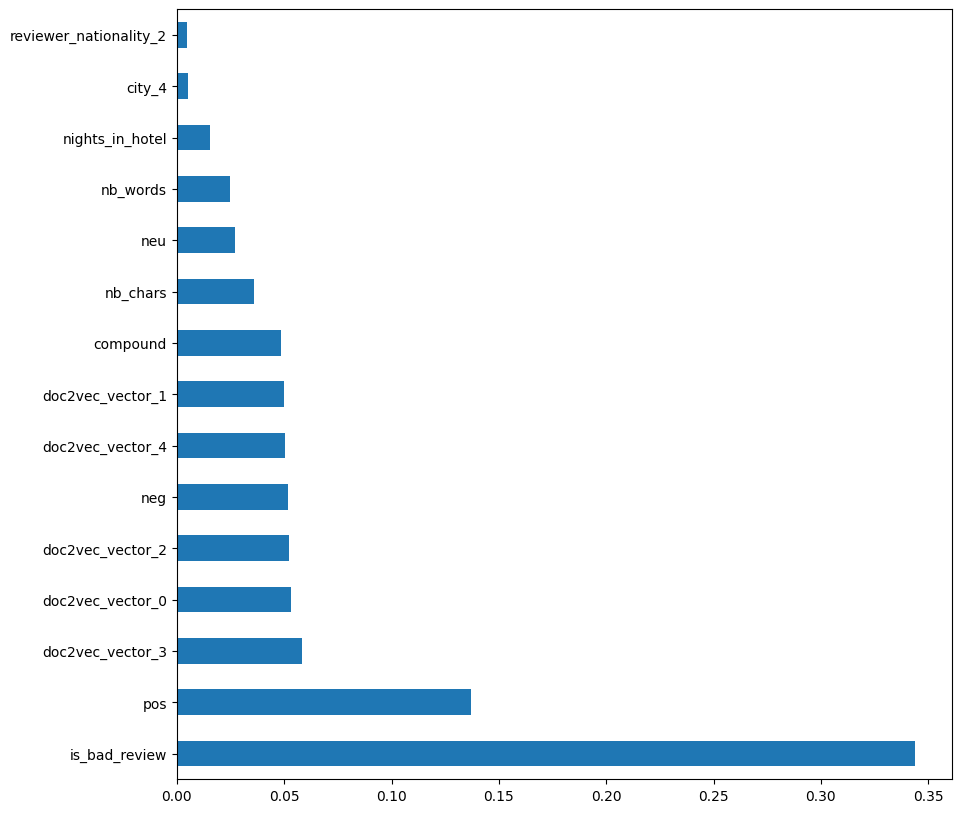

In [470]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [480]:
# выделяем в переменную 15 наиболее значимых для модели признако. Оставляем сэмпл и ревью
important_cols = feat_importances.nlargest(15).index.to_list()
important_cols.extend(['sample', 'reviewer_score'])
important_cols


['is_bad_review',
 'pos',
 'doc2vec_vector_3',
 'doc2vec_vector_0',
 'doc2vec_vector_2',
 'neg',
 'doc2vec_vector_4',
 'doc2vec_vector_1',
 'compound',
 'nb_chars',
 'neu',
 'nb_words',
 'nights_in_hotel',
 'city_4',
 'reviewer_nationality_2',
 'sample',
 'reviewer_score']

Теперь создаем модель с оставшимися признаками

Дополнительный круг с датасетом, с наиболее важными признаками

In [482]:
data = data2.copy()
data = data[important_cols]
data.shape

(167615, 17)

In [483]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [484]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [485]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 16), (38680, 16), (38680, 15), (30944, 15), (7736, 15))

In [486]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [487]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [488]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.9062050155118921


In [489]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.11959643461136288


In [493]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [494]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [495]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [497]:
len(predict_submission)

128935

In [498]:
list(sample_submission)

['reviewer_score', 'id']

In [499]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,3.597,488440
1,3.895,274649
2,3.607,374688
3,3.585,404352
4,3.315,451596
5,4.028,302161
6,4.037,317079
7,3.994,13963
8,3.915,159785
9,3.953,195089
